# Second assessed lab

_The following code loads the MNIST dataset. Build and train your own CNN that achieves an accuracy of at least 99% on the test set. Plot the learning curves of your model._

In [44]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# import TF and keras
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [45]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

First let's create a basic keras sequential neural network to see how well we can classify the handwritten digits using only a simple network. We do this so we can see a baseline network and to see how much we can improve accuracy by creating a convolutional network instead.

In [46]:
from functools import partial
keras.backend.clear_session()

baseline_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28,1]),
    keras.layers.Dense(200, activation = 'relu'),
    keras.layers.Dense(100, activation ='relu'),
    keras.layers.Dense(10, activation = 'softmax')
    ])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 178110 (695.74 KB)
Trainable params: 178110 (695.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's walk through this basic network, layer by layer.
1. First we add a flatten layer, since the images are 28 x 28 pixels that are greyscale, we flatten the input into a 1D array of length 784, for each pixel within the image.
2. We add a dense hidden layer with 200 neurons, each neuron uses the reLu activation function.
3. Then we pass the output of the last hidden layer to the next dense hidden layer of 100 neurons, again using the reLu activation function.
4. Last layer has 10 neurons, one for each digit, which then passes each of the 10 outputs to the softmax activation function.
5. The softmax activation function then converts the passed values into a vector of 10 probabilities, one for each of the 10 digits from 0 to 9, the highest probability is the digit in which the model will classifiy the image as being.

We can now train this model and see how it preforms on the MNIST dataset, we expect it to not be great, but will provide a decent baseline for us to improve upon.

In [47]:
baseline_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
baseline_history = baseline_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6474 - accuracy: 0.8311 - val_loss: 0.2768 - val_accuracy: 0.9270
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3041 - accuracy: 0.9119 - val_loss: 0.2120 - val_accuracy: 0.9392
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2488 - accuracy: 0.9287 - val_loss: 0.1842 - val_accuracy: 0.9500
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2127 - accuracy: 0.9389 - val_loss: 0.1586 - val_accuracy: 0.9554
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1867 - accuracy: 0.9466 - val_loss: 0.1435 - val_accuracy: 0.9616
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1654 - accuracy: 0.9520 - val_loss: 0.1304 - val_accuracy: 0.9638
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1488 - accuracy: 0.9577 - val_loss: 0.1207 - val_accuracy:

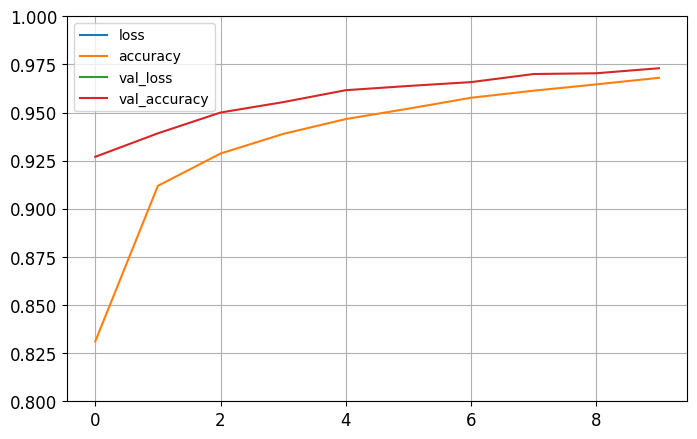

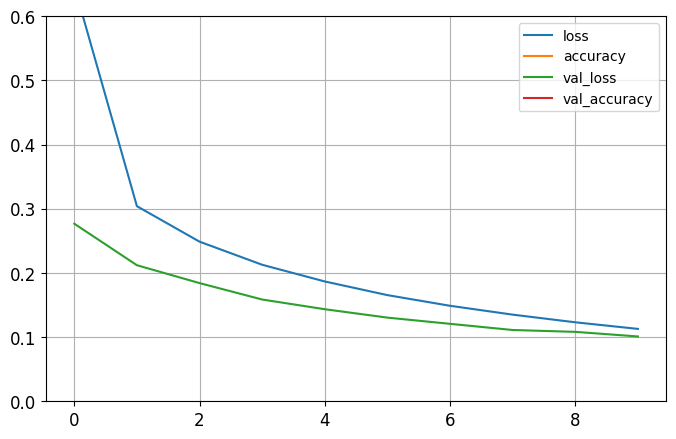

In [50]:
import pandas as pd

pd.DataFrame(baseline_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.show()

pd.DataFrame(baseline_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.6)
plt.show()

We visually see that the model is effectively learning how to make classifcations through each epoch. We can see that the accuracy trends upwards, closer to 1, from epoch 1 to 10. The opposite is true for the loss, it trends downwards. These are both what we expect to see and validates the model is actually learning the patterns of the images.

In [51]:
baseline_score = baseline_model.evaluate(X_test,y_test)
baseline_score

313/313 [==============================] - 1s 2ms/step - loss: 0.1147 - accuracy: 0.9657


[0.11474166065454483, 0.9656999707221985]

We get an accuracy score of about 96%, which is not the greatest for the MNIST dataset, which is a fairly simplified set of images. We can for sure do better than 96%. Since we are passing images into the network, a CNN is perfectly suited for our situation. Its built-in convolutional layer reduces the high dimensionality of images without losing its information.

In [52]:
keras.backend.clear_session()
CNN_model_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [53]:
CNN_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               1

Let's explain what this CNN is actually doing line by line.

1. First a convolutional layer with 32 filters, each having a kernel size of 5x5. These filters slide accross the input image, computing the dot product of each 5x5 grid, which results in a single value, which then this overall results in a smaller grid. It uses the ReLU activation function. The input_shape parameter specifies that the input images are 28x28 pixels with a single channel (greyscale).
2. Next we have a max pooling layer. It reduces the spatial dimensions of the feature maps by taking the maximum value within a 2x2 region.
3. We have our second convolutional layer now on the output of the max pooling layer. 64 filters and a kernel size of 5x5. It uses the ReLU activation function again.
4. Another max pooling layer that does the same thing as the first one, but on the 3rd layers.
5. Now we flatten the output of the two convolution layers to a 1D array as we did in our baseline, only difference is that here we now have reduced the dimensionality of the images.
6. A dense layer with 128 neurons, using the reLu activation function.
7. Again, dense layer with 10 neurons, one for each digit, and then passed through the softmax function so we get a vector of probabilities from the numerical outputs.

In [54]:
CNN_model_1.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
CNN_1_history = CNN_model_1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4478 - accuracy: 0.8743 - val_loss: 0.1265 - val_accuracy: 0.9668
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1183 - accuracy: 0.9651 - val_loss: 0.0813 - val_accuracy: 0.9772
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0834 - accuracy: 0.9753 - val_loss: 0.0715 - val_accuracy: 0.9794
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0680 - accuracy: 0.9792 - val_loss: 0.0618 - val_accuracy: 0.9830
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0576 - accuracy: 0.9822 - val_loss: 0.0564 - val_accuracy: 0.9854
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0507 - accuracy: 0.9846 - val_loss: 0.0489 - val_accuracy: 0.9876
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0448 - accuracy: 0.9859 - val_loss: 0.0483 - val_accuracy:

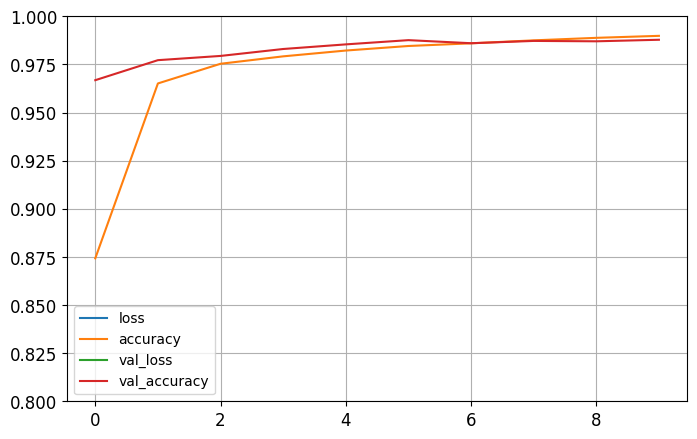

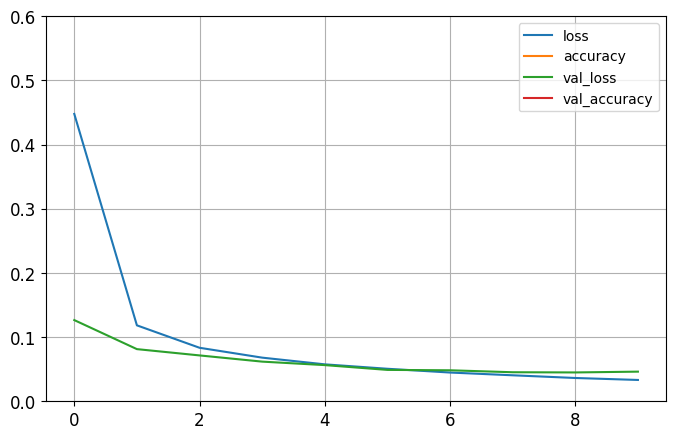

In [58]:
pd.DataFrame(CNN_1_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.show()

pd.DataFrame(CNN_1_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.6)
plt.show()

Again, we see similair situations here, both are what we would expect.

In [59]:
CNN_score_1 = CNN_model_1.evaluate(X_test,y_test)
CNN_score_1

313/313 [==============================] - 1s 3ms/step - loss: 0.0424 - accuracy: 0.9852


[0.04237578809261322, 0.9851999878883362]

Wow, this is much better, we get about 98% accuracy, can we do even better though?

In [60]:
keras.backend.clear_session()
CNN_model_2 = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

CNN_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

In [61]:
CNN_model_2.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
CNN_2_history = CNN_model_1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.0433 - val_accuracy: 0.9888
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0513 - val_accuracy: 0.9856
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0429 - val_accuracy: 0.9880
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0424 - val_accuracy: 0.9886
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0223 - accuracy: 0.9932 - val_loss: 0.0455 - val_accuracy: 0.9886
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0424 - val_accuracy: 0.9888
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0419 - val_accuracy:

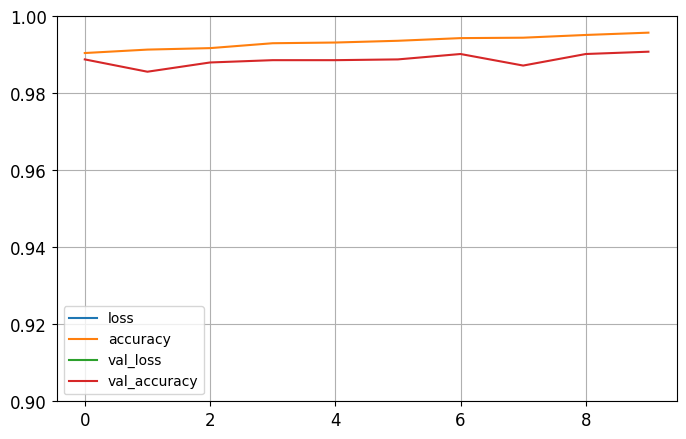

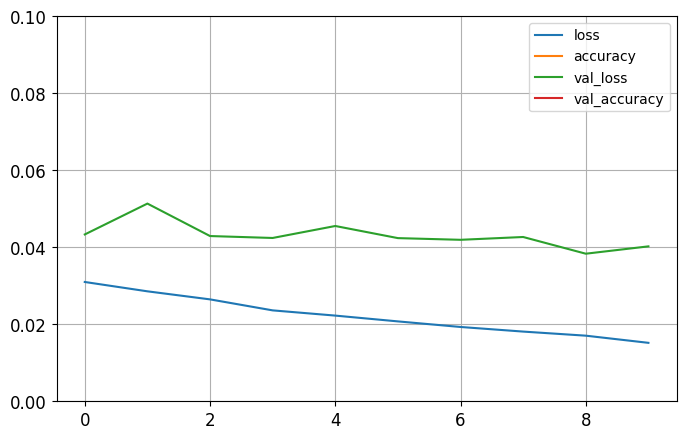

In [64]:
pd.DataFrame(CNN_2_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.9, 1)
plt.show()

pd.DataFrame(CNN_2_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.1)
plt.show()

In [65]:
CNN_score_2 = CNN_model_1.evaluate(X_test,y_test)
CNN_score_2

313/313 [==============================] - 1s 3ms/step - loss: 0.0294 - accuracy: 0.9901


[0.029429567977786064, 0.9901000261306763]

And we get an accuracy of 99% on the dot! This is what we wanted.